### Estimating _calc_date_ with high accuracy based on reference data and on yield-to-worst

Last modified by Charles on 2023/1/14.

Summary of findings: 
The time to calculated estimated _calc_date_ for about one million trades is about 200 milliseconds.
When using true yield to worst, accuracy in estimating _calc_date_ is around 99.98%,
versus 98% with _ytw_preds_ and 95% when using _last_ytw_.

General comments:
For a recent previous version of this notebook, see https://github.com/Ficc-ai/ficc/blob/ficc_ml/ml_models/sequence_predictors/charles_20221212.ipynb.
For a previous version that calculates flags for groups of trades, see https://github.com/Ficc-ai/ficc/blob/ficc_ml/ml_models/sequence_predictors/flags_20230106.ipynb.
This version keeps many analyses and comments from that version and previous ones.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
print("pandas version", pd.__version__)

import time
import datetime
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import colors

from sklearn.ensemble import VotingRegressor

import lightgbm
from lightgbm import LGBMRegressor

import os, gc, psutil, pickle

pandas version 1.5.0


#### Monitoring memory consumption

The best measure of total memory used by the current Python process is unique set size (uss).
The number of pages of memory fetched from disk is pageins.
See https://stackoverflow.com/questions/938733/total-memory-used-by-python-process and elsewhere for explanations.
The _uss()_ function works on my Macbook, but will likely not work on all operating systems.

To do: Find out why memory used as reported by the Macbook Activity Monitor is many times the gigabytes reported by Python.

In [2]:
prevpageins = 0
def uss():
    global prevpageins
    gc.collect()
    info = psutil.Process().memory_full_info()
    newpageins = info.pageins
    diff = newpageins - prevpageins
    if diff > 0:
        print(f"Warning: {diff} new pageins")
        prevpageins = newpageins
    uss = info.uss / 1e9 
    return uss

uss()

0.131661824

#### Comments on achieving efficient code

Pandas keeps track of different versions of the same dataframe in an efficient way,
using memory to store only changes. 
Dataframes should not be updated in-place, because then other dataframes that share the same memory are changed also,
which is undesired behavior.
Dataframes should also not be copied, because that increases memory usage dramatically,
and is slow.

Dataframes are stored with contiguous columns, not contiguous rows.
Therefore, "apply" for every row of a dataframe is intrinsically slow compared to operations on entire columns.
Where possible, avoid using "apply" at all.
Instead, use operations that work on entire columns of a dataframe.

Pandarallel is both slow and memory-intensive.

We want to make it easy to release memory used by variables, in particular dataframes. 
However, memory can be garbage-collected only if all names that refer to it are out of scope.
Therefore, we should minimize the number of new dataframe variables, since each one is an alias that may prevent garbage collection.

To do: 
- Find a way to guarantee that all names referring to a given dataframe are out of scope.
- Find out with certainty whether doing garbage collection after deleting all aliases for a dataframe is successful in reclaiming memory.
- Verify that it is never optimal to use _.copy(_. 

In [3]:
pd.options.mode.chained_assignment = None            # disable warnings about too many changes to a dataframe, but these warnings can still appear
pd.options.display.precision = 3
pd.options.display.width = 160
pd.options.display.max_rows = 300
pd.options.display.min_rows = 15

#### Loading data from a local pickle file

We download the data manually from a GCP bucket to a local file, then load that into pandas.
Depending on garbage collection, loading the data may sometimes seem to use negative memory.

This lets us try different ideas in feature engineering and model design far quicker.
Just as important, it makes downstream work more pleasant and 
makes us much more motivated to find and fix errors. 
<!-- Fast data processing is absolutely crucial, in particular, when a bug causes the Python kernel to crash,
and all previous computation in the notebook is lost. -->

In [4]:
%%time
before = uss()

prefix = "/Users/gil/git/ficc/notebooks/measures_accuracy/"
name = "gbm_processed_file_0119.pkl"

limitation = ""
path = f"{prefix}{limitation}{name}"

f = open(path, 'rb')
data = pd.read_pickle(f)

after = uss()
print(f"\nLoaded {len(data)} rows from {path} using {after - before:.3f} gigabytes in {after:.3f} total gigabytes")


Loaded 1390496 rows from /Users/gil/git/ficc/notebooks/measures_accuracy/gbm_processed_file_0119.pkl using 4.541 gigabytes in 4.673 total gigabytes
CPU times: user 7.97 s, sys: 3.13 s, total: 11.1 s
Wall time: 11.5 s


In [5]:
data['publish_seconds'] = (data.publish_datetime - data.trade_datetime).dt.total_seconds()
data['settlement_days'] = (data.settlement_date - data.trade_datetime).dt.total_seconds() / 86400

dt = pd.to_datetime(data.trade_datetime).dt
data['month'] = dt.month
data['day_of_year'] = dt.day_of_year

data['hour_of_day'] = dt.hour.astype('category')
# print( data.hour_of_day.value_counts().sort_index() )

data['weekday'] = dt.day_name().astype('category')
# data.weekday.value_counts()

#### Making a pandas dataframe smaller

The following function reduces memory usage by more than 50%.

In [6]:
def compact(data):
    ocols = data.select_dtypes(['object']).columns
    for col in ocols:
        try:
            data[col] = data[col].astype('category')
        except Exception as e: 
            print(f"   *** exception {e} for {col} ***")   
            
    fcols = data.select_dtypes(['float']).columns
    for col in fcols: 
        try:
            if data[col].abs().max() > 100: continue
            if data[col].nunique() > 100: continue
            if not data[col].equals(data[col] // 1): continue
            # print(f"converting {col} to int8")
            data[col] = data[col].fillna(-99).astype(np.int8)
        except Exception as e: 
            print(f"   *** exception {e} for {col} ***")
            
    icols = data.select_dtypes('integer').columns
    data[icols] = data[icols].apply(pd.to_numeric, downcast='integer')
    
    fcols = data.select_dtypes('float').columns
    data[fcols] = data[fcols].apply(pd.to_numeric, downcast='float')
    return data

In [7]:
earliest = 9
data = data[data.month >= earliest]
print(f"compacting {len(data)} rows")
%time data = compact(data)
uss()

compacting 978710 rows
   *** exception unhashable type: 'numpy.ndarray' for trade_history ***
   *** exception unhashable type: 'numpy.ndarray' for target_attention_features ***
CPU times: user 38.1 s, sys: 15.7 s, total: 53.9 s
Wall time: 53.9 s


2.585923584

In [8]:
%time data.info(verbose=False, show_counts=True, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 978710 entries, 438685 to 1477105
Columns: 284 entries, MSRB_maturity_date to weekday
dtypes: bool(35), category(58), datetime64[ns, UTC](4), datetime64[ns](43), float32(77), float64(7), int16(2), int32(5), int64(1), int8(50), object(2)
memory usage: 1.5 GB
CPU times: user 608 ms, sys: 26.3 ms, total: 634 ms
Wall time: 635 ms


#### Features for supply and demand

The _cumsum_ features measure the cumulative volume of each cusip in each direction on each day.
To make the cumulative sum start in the morning and increase during the day,
we must sort the rows by increasing datetime.
Note that sums are in hundreds of dollars, because of _rounded_.
To do: Fix the logic here and elsewhere to take into account publish times.

In [9]:
%%time
rounded = 100
data = data.sort_values(by='trade_datetime', ascending=True).copy()
qty = np.round(10**data.quantity / rounded)
    
data['S_qty'] = (data.trade_type == "S") * qty
data['P_qty'] = (data.trade_type == "P") * qty
data['D_qty'] = (data.trade_type == "D") * qty

g = data.groupby(['day_of_year', 'cusip'], observed=True)
data['cumsum_S'] = g.S_qty.cumsum()
data['cumsum_P'] = g.P_qty.cumsum()
data['cumsum_D'] = g.D_qty.cumsum()
data['diff_cumsum'] = data.cumsum_S - data.cumsum_P
data['tot_cumsum'] = data.cumsum_S + data.cumsum_P + data.cumsum_D

CPU times: user 1.44 s, sys: 519 ms, total: 1.95 s
Wall time: 1.96 s


#### YCL to refund is meaningless when _called_redemption_type_ is 19, or _refund_date_ is none or in the past

The refund date is in the past when _called_redemption_type_ is 19, because these bonds are refunding, not refunded,
and _refund_date_ refers to the refund date of the refunded bond.
The distributions of the four _ycl_to_refund_ columns look reasonable after these restrictions.
However, we find below that _last_real_time_ficc_ycl_to_refund_ has anomalies.

To do: Understand bonds with refund dates far in the future.

In [10]:
s = (data.called_redemption_type == 19) & ~data.ficc_ycl_to_refund.isna()
print(s.sum())
data.loc[s,['ficc_ycl_to_refund']] = np.nan

s = (data.called_redemption_type == 19) & ~data.last_ficc_ycl_to_refund.isna()
print(s.sum())
data.loc[s,['last_ficc_ycl_to_refund']] = np.nan

days_to_refund = (data.refund_date - data.settlement_date).dt.days
s = (days_to_refund <= 0) & ~data.ficc_ycl_to_refund.isna()
print(s.sum())
data.loc[s,['ficc_ycl_to_refund']] = np.nan

last_days_to_refund = (data.last_refund_date - data.last_settlement_date).dt.days
s = (last_days_to_refund <= 0) & ~data.last_ficc_ycl_to_refund.isna()
print(s.sum())
data.loc[s,['last_ficc_ycl_to_refund']] = np.nan

s = data.last_refund_date.isna() & ~data.last_ficc_ycl_to_refund.isna()
print(s.sum())
data.loc[s,['last_ficc_ycl_to_refund']] = np.nan

s = data.refund_date.isna() & ~data.ficc_ycl_to_refund.isna()
print(s.sum())
data.loc[s,['ficc_ycl_to_refund']] = np.nan

3643
3641
0
0
0
0


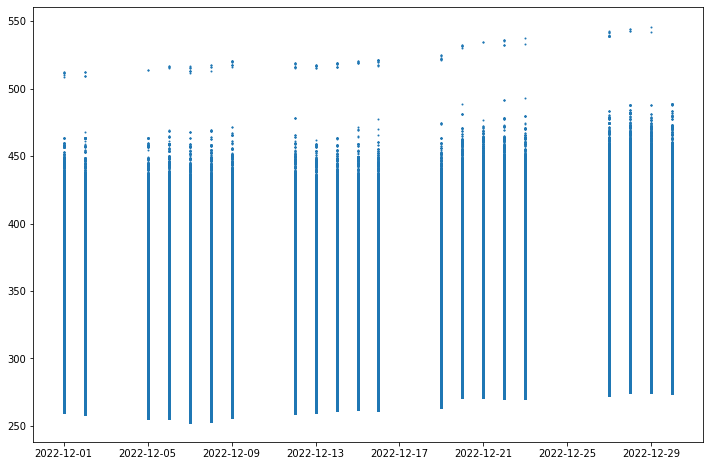

In [11]:
plt.figure(figsize=(12,8))
plt.scatter(data.trade_date, data.ficc_ycl, s=1);

#### Preprocessing features for interest rates

We log-transform columns if needed, create the yield-to-worst label if needed, and check that it is correct.
Reminder: "size" and "yield" are special words in Python, so we cannot write data.yield, and data.size is a scalar, not a column.
The columns par_traded and quantity both contain the size of the current trade.
Also, we convert all interest rates and spreads to basis points: 
if the standard deviation before conversion is less than 10, then values are multiplied by 100.

The 20 year Treasury rate is above the 30 year rate, because the 20 year bonds are unpopular with investors; see https://www.ustreasuryyieldcurve.com/.
To do: Investigate _delta_ycl_ and _real_time_spread_.

In [12]:
%%time
for col in ['par_traded', 'quantity', 'last_size', 'last_seconds_ago']:
    data[col] = data[col].astype('float64')
    avg = np.mean(data[col])
    print(col, avg)
    if avg > 10:
        low = data[col].min()
        if low >= 1:
            data[col] = np.log10( data[col] )
        elif low >= 0:
            data[col] = np.log10( data[col] + 1 )
        else:
            print(f"   *** minimum value of {col} is {low}")
        
if not 'ytw' in data.columns:
    data['ytw'] = data['yield']
            
for col in data.columns:
    candidate = "rate" in col or "ycl" in col or "ytw" in col or "yield" in col or "spread" in col
    others = "state" in col or "exists" in col or "error" in col or "diff" in col
    others = others or "has_" in col or "_preds" in col or "_err" in col or "_ae" in col
    if candidate and not others:
        vals = data[col].astype('float64')
        if vals.std() < 10:
            vals = vals * 100
            data[col] = vals
        print( f"{col:40} {data[col].dtype}    {vals.min():7.2f}  {vals.mean():7.2f}  {vals.max():7.2f}" )
        
data['ted_spread'] = (data.t_rate_10 - data.t_rate_2)
uss()

par_traded 149162.93624771383
quantity 4.6266853688835585
last_size 154690.92254381804
last_seconds_ago 1966613.3949357853
MSRB_coupon_rate                         float64       0.00   419.90  2000.00
yield                                    float32      40.00  35402.72  743530.00
current_coupon_rate                      float64       0.00   419.90  2000.00
original_yield                           float64       8.00   246.66  1043.50
last_yield_spread                        float32    -409.56    57.82  8818.27
last_yield                               float64       0.10   352.69  9117.50
ficc_ycl                                 float32     252.83   295.46   545.93
ficc_ycl_3_month                         float32     270.51   290.06   310.40
ficc_ycl_1_month                         float32     272.76   293.33   314.35
yield_spread                             float32    -386.99    58.57  7122.56
treasury_rate                            float64     342.00   388.70   477.00
ficc_treasury_sp

1.775853568

#### Creating new predictors and new targets

The general idea is that we want predictors based on the last trade to be consistent with targets:
- ideally, both should use real-time yield curve levels (YCLs)
- the target should use the categorical _calc_day_cat_ of the last trade (this is the prefix _same_)
- further, the target should use the same duration as the last trade (this is the prefix _new_).

The prefix _rt_ means real-time and the prefix _dur_ means using the same duration.
The column _rt_last_ficc_ycl_ is unreliable because the values of _last_real_time_ficc_ycl_to_XXX_ need to be fixed.
The prefixes _last_ and _trans_ use the same _calc_day_cat_, but not the exact same duration for _trans_.

Reminder: The values of _calc_day_cat_ are 0, next_call_date; 1, par_call_date; 2, maturity_date; or 3, refund_date.

In [13]:
# print the correlation and MAE between two columns, ignoring NaN values
def corrmae(df,u,v):
    names = u + " & " + v
    mae = (df[u] - df[v]).abs().mean()
    avg = df[v].mean()
    print( f"{names:>40}:  corr {mycorr(df,u,v):5.3f}   mae {mae:6.2f}" )

# create yield curve levels as of the last trade; use the cutoff to remove outlier real-time values
def mklastycl(df, cutoff = 5):
    last_ficc_ycl = 0 * df.last_yield_spread
    # rt_last_ficc_ycl = 0 * df.last_yield_spread
    
    trans_ficc_ycl = 0 * df.last_yield_spread          # YCL translated to now for duration now of calc_day_cat for last trade
    # rt_trans_ficc_ycl = 0 * df.last_yield_spread
    
    sub = df.last_calc_day_cat == 0                    # can't make this a loop over [0,1,2,3]
    last_ficc_ycl[sub]     = df[sub].last_ficc_ycl_to_next_call
    # rt_last_ficc_ycl[sub]  = df[sub].last_real_time_ficc_ycl_to_next_call
    trans_ficc_ycl[sub]    = df[sub].ficc_ycl_to_next_call
    # rt_trans_ficc_ycl[sub] = df[sub].real_time_ficc_ycl_to_next_call

    sub = df.last_calc_day_cat == 1
    last_ficc_ycl[sub]     = df[sub].last_ficc_ycl_to_par_call
    # rt_last_ficc_ycl[sub]  = df[sub].last_real_time_ficc_ycl_to_par_call
    trans_ficc_ycl[sub]    = df[sub].ficc_ycl_to_par_call
    # rt_trans_ficc_ycl[sub] = df[sub].real_time_ficc_ycl_to_par_call

    sub = df.last_calc_day_cat == 2
    last_ficc_ycl[sub]     = df[sub].last_ficc_ycl_to_maturity
    # rt_last_ficc_ycl[sub]  = df[sub].last_real_time_ficc_ycl_to_maturity    # this is where the error is
    trans_ficc_ycl[sub]    = df[sub].ficc_ycl_to_maturity
    # rt_trans_ficc_ycl[sub] = df[sub].real_time_ficc_ycl_to_maturity

    sub = df.last_calc_day_cat == 3
    last_ficc_ycl[sub]     = df[sub].last_ficc_ycl_to_refund
    # rt_last_ficc_ycl[sub]  = df[sub].last_real_time_ficc_ycl_to_refund
    trans_ficc_ycl[sub]    = df[sub].ficc_ycl_to_refund
    # rt_trans_ficc_ycl[sub] = df[sub].real_time_ficc_ycl_to_refund

    # fix errors in rt_last_ficc_ycl approximately    
    # tofix = (rt_last_ficc_ycl - last_ficc_ycl).abs() >= cutoff
    # rt_last_ficc_ycl[tofix] = last_ficc_ycl[tofix] 
    
    return last_ficc_ycl, trans_ficc_ycl

# create alternative predictors; remember that last_yield_spread and last_ficc_ycl are not real-time
def mkcols(data):
    data['last_ytw']   = data.last_yield_spread + data.last_ficc_ycl        # reconstructing the MSRB labels from non-real-time columns
    # data['rt_last_ys'] = data.last_ytw - data.rt_last_ficc_ycl              # real-time yield spread of the last trade; error propagates here

    data['adj_last_ytw']        = data.last_ytw - data.last_ficc_ycl    + data.trans_ficc_ycl               # not real-time, categorical calc day
    # data['rt_adj_last_ytw']     = data.last_ytw - data.rt_last_ficc_ycl + data.rt_trans_ficc_ycl            # the error propagates here
    data['dur_adj_last_ytw']    = data.last_ytw - data.last_ficc_ycl    + data.new_ficc_ycl 
    # data['rt_dur_adj_last_ytw'] = data.last_ytw - data.rt_last_ficc_ycl + data.new_real_time_ficc_ycl     # the error propagates here

    # create alternative targets
    data['new_ys']     = data.ytw - data.new_ficc_ycl                       # using last_duration but not real-time; has error from new_ficc_ycl
    # data['rt_new_ys']  = data.ytw - data.new_real_time_ficc_ycl           # should be the best: real-time and using last_duration!

    data['same_ys']    = data.ytw - data.trans_ficc_ycl                     # using categorical last calc date
    # data['rt_same_ys'] = data.ytw - data.rt_trans_ficc_ycl
    return data

In [14]:
data['last_ficc_ycl'], data['trans_ficc_ycl'] = mklastycl(data)
data = mkcols(data) 

The data file from September 12 has many fewer columns than earlier files.
This is fixed in the September 27 file and later. However, that file leads to worse accuracy,
despite similar preprocessing in this notebook.
To do: Investigate why.

#### Removing duplicate columns

We drop some columns if they are confirmed to be exact duplicates. 
To do: 
- Check efficiently for every pair of columns whether they have identical values. 
In principle, this can be done with data.T.drop_duplicates().T, but there are problems in practice, including but not limited to inefficiency.
- Remove columns that are duplicates but with different types, or with different numerical precision, such as the coupon columns.
- Write code that computes mutual information efficiently, to identify columns that contain the same information
but coded with different values.
- Fix errors in the types of the coupon columns, and in "dropdupcol(data, 'coupon', 'MSRB_coupon_rate')".

MSRB_coupon_rate and coupon should be identical, but have different types.

In [15]:
def dropdupcol(df,a,b):
    if not a in df.columns:
        print("absent column", a)
        return df
    if not b in df.columns:
        print("absent column", b)
        return df    
    if df[a].equals(df[b]):
        print(f"dropping column {b} and keeping identical {a}")
        df = df.drop([b], axis=1)
    else:
        print(f"\ncolumns {a} and {b} are different:")
        print(df[a].value_counts(dropna=False)[0:5], "\n", df[b].value_counts(dropna=False)[0:5])
    return df

In [16]:
%%time
data = dropdupcol(data, 'issue_key', 'issue_key_copy')
data = dropdupcol(data, 'is_callable', 'callable')
data = dropdupcol(data, 'is_called', 'called')
data = dropdupcol(data, 'cusip', 'msrb_cusip')
data = dropdupcol(data, 'has_zero_coupons', 'zerocoupon') 
uss()

absent column issue_key_copy
dropping column callable and keeping identical is_callable
dropping column called and keeping identical is_called
dropping column msrb_cusip and keeping identical cusip

columns has_zero_coupons and zerocoupon are different:
False    966650
True      12060
Name: has_zero_coupons, dtype: int64 
 False    966477
True      12233
Name: zerocoupon, dtype: int64
CPU times: user 864 ms, sys: 367 ms, total: 1.23 s
Wall time: 1.23 s


1.749004288

To do: Figure out why the coupon columns are not identical.

#### Letting the model learn the effect of changes in the direction of the trade

_ttypes_ is the cross-product of the direction (D, P, or S) of the last trade and the target trade.

In [17]:
def concat(a,b):
    return (a.astype(str) + b.astype(str)).astype('category')

def mkttypes(df):
    df['ttypes'] = concat(df.last_trade_type, df.trade_type)
    return df

data = mkttypes(data)

#### A few additional predictors

The existing field _when_issued_ is almost identical with _new_issue_. 
The exceptions include trades in a refunding bond, cusip 455054BH8, and we know that these bonds are complicated.
To do: 
- Write a function that automatically analyzes cells with small counts in a cross-tabulation.
- Add a team member's answers why _when_issued_ and _new_issue_ are not identical.

In [18]:
data['par_issue'] = data.issue_price == 100
data['prev_trade_today'] = (data.last_seconds_ago > 0) & (data.last_seconds_ago <= 4.5)

if 'is_lop_or_takedown' in data.columns:
    data['is_takedown'] = data.is_lop_or_takedown & (data.dollar_price < data.issue_price)
    data['is_lop'] = data.is_lop_or_takedown & (data.dollar_price == data.issue_price)

if 'primary_market_settlement_date' in data.columns:
    data['new_issue'] = data.trade_date < data.primary_market_settlement_date
    print( pd.crosstab(data.new_issue, data.when_issued), "\n" )
    data['days_from_issue'] = (data.trade_date - data.primary_market_settlement_date).dt.days
    
mindays = 10**data.days_to_maturity
earlier = (data.days_to_call > 0) & (10**data.days_to_call < mindays)
mindays[earlier] = 10**data.days_to_call
earlier = (data.days_to_refund > 0) & (10**data.days_to_refund < mindays)
mindays[earlier] = 10**data.days_to_refund
data['mindays'] = mindays

when_issued   False  True 
new_issue                 
False        971226      0
True              0   7484 



#### Dropping constant columns

Next, we drop all columns that are constant. 
The argument _dropna=False_ for the method _nunique_ allows NaN to be a possible unique value.

In [19]:
%%time
for col in data.columns:
    try: 
        if data[col].nunique(dropna=False) <= 1:
            # print(col)
            data = data.drop(col, axis=1)
    except Exception as e: 
        print(f"   *** exception {e} for {col} ***")
uss()

   *** exception unhashable type: 'numpy.ndarray' for trade_history ***
   *** exception unhashable type: 'numpy.ndarray' for target_attention_features ***
CPU times: user 7.31 s, sys: 2.56 s, total: 9.87 s
Wall time: 9.87 s


1.757073408

#### Fixing data types

We make sure that dates and times have the right type. To do: Make all include an explicit timezone..

To do: Identify and fix all remaining erroneous types, and warning messages.

In [20]:
for col in data.columns:
    timetype = 'datetime64[ns]'
    if col.startswith("time") or col.endswith("time") or col.endswith("date"):
        try:
            data[col] = data[col].astype(timetype)
            # print(col)
        except Exception as e: 
            print(f"   *** exception {e} for {col} ***")    

   *** exception Cannot cast object dtype to datetime64[ns] for time_of_trade ***
   *** exception Cannot cast object dtype to datetime64[ns] for publish_time ***


/var/folders/4p/6gk1pj4j1439gxdnw_vb8prw0000gn/T/ipykernel_59685/455803093.py:5: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  data[col] = data[col].astype(timetype)


In [21]:
MISSINGVAL = np.nan

Columns with exactly two values are converted into Booleans.
To do: Look at columns with two truth values, and missing values. 
Convert some to Boolean, and make others into one-hot encoding.

In [22]:
%%time
for col in data.columns:
    try:
        if data[col].nunique(dropna=False) == 2:
            # print(col)
            data[col] = data[col].astype('bool')
    except Exception as e: 
        print(f"   *** exception {e} for {col} ***")    
uss()

   *** exception unhashable type: 'numpy.ndarray' for trade_history ***
   *** exception unhashable type: 'numpy.ndarray' for target_attention_features ***
CPU times: user 2.32 s, sys: 522 ms, total: 2.84 s
Wall time: 2.84 s


1.796141056

Many numerical fields are actually categorical, so we convert them.
Dictionaries explaining the values of categorical fields are in https://docs.google.com/spreadsheets/d/172OKmkParOjg9r-N4qWjoTdPxQIZoJ1z/edit#gid=655976637.
For example, "use of proceeds = 31" means "Lifecare/retirement centers."
To do: Design a more sophisticated way to identify which features are categorical, versus numerical.

Note that in the 12/28 data file, some values of _last_calc_day_cat_ are invalid. This is a bug that was fixed months ago.
The value -99 is the replacement for _np.nan_ used in the datatype _int8_.

In [23]:
data.last_calc_day_cat.value_counts(dropna=False)

 2     560425
 0     381297
 3      36404
 1        466
-99       118
Name: last_calc_day_cat, dtype: int64

In [24]:
%%time
minvalues = 25

candidates = data.select_dtypes(include=[np.number])
exclude = { 'de_minimis_threshold', 'num_prev_messages', 'days_to_settle', 'last_yield_spread', 'month'}
candidates = set(candidates.columns) - exclude

for col in candidates:
    nun = data[col].nunique(dropna=False)
    if nun < minvalues and not "refund" in col and not "ycl" in col and not "price" in col and not "rate" in col \
                and not "count" in col and not "days" in col:
        # print(col, nun)
        data[col] = data[col].astype('category')
uss()

CPU times: user 2.32 s, sys: 749 ms, total: 3.07 s
Wall time: 3.07 s


1.813024768

#### Features to capture changes in a bond's characteristics

Changes in yield curve level have some slight predictive power.
To do: Find out why, without ".copy()" below, "PerformanceWarning: DataFrame is highly fragmented" occurs even though this warning has been turned off.

using the 360/30 convention.
This feature turns out to be an important predictor.
Important: In the 12/16/22 data file, last duration is measured in days.
In the 12/28/22 data file, last duration is missing, so I calculate it approximately, using calendar days.

In [25]:
data = data.copy()
data['diff_maturity'] = data.maturity_date != data.last_maturity_date
data['diff_next_call'] = data.next_call_date != data.last_next_call_date
data['diff_par_call'] = data.par_call_date != data.last_par_call_date
data['diff_refund'] = data.refund_date != data.last_refund_date

data['diff_ycl_to_maturity'] = data.ficc_ycl_to_maturity - data.last_ficc_ycl_to_maturity
data['diff_ycl_to_next_call'] = data.ficc_ycl_to_next_call - data.last_ficc_ycl_to_next_call
data['diff_ycl_to_par_call'] = data.ficc_ycl_to_par_call - data.last_ficc_ycl_to_par_call
data['diff_ycl_to_refund'] = data.ficc_ycl_to_refund - data.last_ficc_ycl_to_refund

data['diff_size'] = data.quantity - data.last_size

data['issuer'] = data.cusip.str[:6].astype('category')
data['last_duration'] = (data.last_calc_date - data.last_settlement_date).dt.days
data['yrs_duration'] = np.round(data.last_duration / 365.25)

#### Creating features for absolute values

If a numerical feature is predictive, then its unsigned value may be predictive also.
If a feature is flagged as a leaker, then code below flags its _abs__ version also.

In [26]:
THRESH = 0.001
ds = data.select_dtypes(include=[np.number])
thresh = 0
for col in ds.columns:
    newcol = 'abs_' + col
    if newcol in set(data.columns): continue
    vals = data[col]
    # vals = vals[vals != MISSINGVAL]
    if ((vals < 0).mean() > THRESH) and ((vals > 0).mean() > THRESH):
        # print(newcol)
        data[newcol] = np.abs(vals)
uss()

1.986584576

#### Functions to evaluate and display the accuracy of a model

For _maeval_, _extra_ is a list of additional predictors.
The dataframe columns added by _maeval_ persist after this function finishes,
in order to enable comparisons between the predictions of different models.

The MAE printed by _drawpoints_ is for dealer-dealer trades of \$500,000 or more, 
which are what we call "true mid."
To increase the sample size, we can optionally include dealer-sells trades,
which empirically have slightly smaller MAE than dealer-dealer trades.

To do: Fix missing legends on extreme points in the plot from _drawpoints_.

In [27]:
# create column "name" if needed, then assign values to it for certain rows
def extend(df, name, rows, vals):
    assert len(df) == len(rows), "*** len(df) != len(rows)"
    if len(vals) == len(df): 
        vals = vals[rows]
    assert len(vals) == np.sum(rows), "*** len(vals) != np.sum(rows)"
    
    if not name in df.columns: 
        df[name] = 0.0
    df.loc[rows,name] = vals
    return

# extend certain rows of a dataframe with predicted values and errors
def maeval(df, rows, model, label, extra=[], minus=[]):
    print(np.sum(rows))

    dfp = model.predict( gbmprep(df[rows], extra, minus) )
    extend(df, label + "_preds", rows, dfp )

    delta = df.loc[rows,label] - dfp
    extend(df, label + "_err", rows, delta )
    
    da = delta.abs()
    extend(df, label + "_ae", rows, da )

    n = len(da)
    base = f"\n{label} {n} {extra} bias {delta.mean():5.2f}\t MAE {da.mean():5.2f} +/- {da.std():.2f}"
    print( base + f" ({da.std()/np.sqrt(n):.2f})\t median {da.median():5.2f}" )
    return df

threshold = 2.5e6
directions = ['D']

# show predicted versus actual, and trades with the largest value of the error metric "sortby"
# label should be the column name for true values, also called the target
def drawpoints(df, rows, label, showplot=True, sortby=""):
    df = df[rows]
    label_preds = label + "_preds"
    label_ae = label + "_ae"
        
    # keep = (10**df.quantity >= threshold/5)    # removes too many rows due to imprecise arithmetic
    keep = (10**df.quantity > threshold/5 - 1)
    # keep = (df.par_traded >= threshold/5)
    keep = keep & df.trade_type.isin(directions)
    df = df[keep]
    
    if label   == 'new_ys':       ytw_preds = df[label_preds] + df.new_ficc_ycl
    elif label == 'same_ys':      ytw_preds = df[label_preds] + df.trans_ficc_ycl
    elif label == 'diff_ys':      ytw_preds = df[label_preds] + df.new_ficc_ycl + df.last_yield_spread
    elif label == 'yield_spread': ytw_preds = df[label_preds] + df.ficc_ycl
    elif label == 'ytw':          ytw_preds = df[label_preds]
    else: ytw_preds = df.ytw
    
    ytw_ae = (df.ytw - ytw_preds).abs().mean()
    
    r, g, b = colors.to_rgb('red')
    w = np.minimum( np.array(10**df.quantity), threshold)
    opacity = w / threshold
    color = [(r, g, b, alpha) for alpha in opacity]

    if showplot:
        plt.figure(figsize=(12,12))
        plt.scatter(df[label], df[label_preds], s=5, c=color)

    da = df[label_ae]
    n = len(da)
    print( f"\nLarge {directions} n={n}\t {label} MAE = {da.mean():.2f} +/- "\
          + f"{da.std():.2f} ({da.std()/np.sqrt(n):.2f}) median {da.median():.2f}     YTW MAE = {ytw_ae:.2f}" )
    if sortby == "": 
        sortby = label_ae
        name = label
    else:
        name = sortby
    kern = 60 + len(name)*7

    top = df.sort_values(by=[sortby], ascending=False).iloc[:100,:]
    top = top.drop_duplicates(['issuer'])

    for (bond, d, x, y, lastytw, ytw, err, lastdp, dp, side, lastside, days, lastys, back, lastsize, nowsize, n) in \
                zip( top.cusip, top.trade_datetime, top[label], top[label_preds], top.last_ytw, top.ytw, top[sortby], \
                     top.last_dollar_price, top.dollar_price, top.trade_type, top.last_trade_type, top.last_duration, \
                     top.last_yield_spread, top.last_seconds_ago, top.last_size, top.par_traded, range(100) ):
        if n >= 5: break
        seconds_ago = 10**back
        if seconds_ago > 43200:
            ago = str(int(np.ceil(seconds_ago / 86400))) + "d"
        else:
            ago = str(int(np.floor(seconds_ago / 60))) + "min"
      
        print( f"{bond:9} {d:%m-%d}  back {ago:>6}: {10**lastsize/1000:5.0f}K {lastside:1}{lastytw:4.0f} ${lastdp:6.2f} dur {days:5.0f} " \
              + f"ys {lastys:4.0f}  now: {10**nowsize/1000:5.0f}K {side:1}{ytw:4.0f} ${dp:6.2f}  true {x:7.2f} {y:7.2f} diff {x-y:7.2f}" )
                
        if showplot:
            plt.scatter(x,y, s=40, c = 'green')
            if (x < y): 
                plt.annotate(name + " " + bond, (x-kern,y-2.5))
            else:
                plt.annotate(name + " " + bond, (x+10,y-2.5))

#### Features not to use

Print a representative value for columns that have discrete values.
Do not use features with more than _maxdiscrete_ discrete values.
To do: Design a way to get predictive power from high-cardinality discrete features.

In [28]:
maxdiscrete = 70
TOOMANY = { 'ice_organization_id' }

for col in data.select_dtypes(include='category').columns:
    nun = data[col].nunique()
    vc = data[col].value_counts(dropna=False)
    vals = vc.index.to_numpy()
    if nun >= 3:
        third = vals[2]
    else:
        third = vals[0]
    # print(f"{col:32s} {nun:10}   {str(third):20s}")
    if nun >= maxdiscrete: TOOMANY = TOOMANY | {col}
print(TOOMANY)

BASIC = { 'calc_date', 'calc_day_cat', 'calc_date_month', 'days_to_calc', 'yrs_to_calc', 'last_rtrs_control_number', \
          'duration', 'status', 'floor', 'scary', 'spread', 'calc_price', 'trade_history', 'rough' }

TARGETS = {'yield', 'ytw', 'yield_spread', 'ys', 'same_ys', 'new_ys', 
           'maturity_ys', 'ys_at_maturity', 'call_ys', 'ficc_ycl', 'delta', 'delta_ycl', \
           'dollar_price', 'price_to_maturity', 'price_to_next_call', 'price_to_par_call' }

def mkleakers(TARGETS):
    BASE = BASIC | TARGETS
    EXTENDED = BASE

    for col in BASE: EXTENDED = EXTENDED | { "rt_" + col }
    for col in BASE: EXTENDED = EXTENDED | { "real_time_" + col }
    for col in BASE: EXTENDED = EXTENDED | { "diff_" + col }
    for col in BASE: EXTENDED = EXTENDED | { col + "_diff" }
    for col in BASE: EXTENDED = EXTENDED | { col + "_ae" }
    
    BASE = EXTENDED
    for col in BASE: EXTENDED = EXTENDED | { col + "_preds" }
    for col in BASE: EXTENDED = EXTENDED | { col + "_err" }
    for col in BASE: EXTENDED = EXTENDED | { col + "_ae" }

    BASE = EXTENDED
    for col in BASE: EXTENDED = EXTENDED | { "abs_" + col }
    return EXTENDED

def gbmprep(df, plus, minus):
    LEAKERS = mkleakers(TARGETS)
    USECOLS = set(df.select_dtypes(include=['category','bool','number']).columns) - (LEAKERS | TOOMANY)
    return df[ list( ( USECOLS | set(plus) ) - set(minus) ) ]

{'series_id', 'series_name', 'cusip', 'additional_project_txt', 'use_of_proceeds_supplementary', 'project_name', 'issue_text', 'escrow_obligation_agent', 'time_of_trade', 'issuer', 'instrument_primary_name', 'ice_organization_id', 'publish_time', 'organization_primary_name', 'security_description'}


#### LightGBM benchmark models

We use LightGBM for exploration, because it is fast.
This can reveal whether some predictors are obvious leakers,
and whether a neural network is likely to provide decent accuracy.
_myLGBM_ has hyperparameters that informally balance between underfitting and overfitting for this domain.
Different random seed values can give models with accuracies that vary by more than one basis point.
Subsampling guarantees randomness in training even with small training sets.

The choice of random seed influences strongly the accuracy achieved by a single LightGBM model.
To reduce this variability, we train an ensemble of multiple models.
With _n_ = 4 models, the standard error should be reduced by 50\%,
and by 68\% with 10 models.
By training in parallel, the time to train 10 models is only about 3x the time for one model, on my Macbook M1.

Importance plots based on gain are more fine-grained, 
and agree better with intuition about the relative predictive power provided by different features.

#### Splitting the data into training and testing sets

For November 2022 as test set, previous months are used for training.

In [29]:

defaultdepth = 8
defaultseed = 77
defaultloss = 'mae'

def myLGBM(seed = defaultseed, depth = defaultdepth, loss = defaultloss):
    return LGBMRegressor(max_depth=depth, num_leaves=depth*10, n_estimators=depth*30, objective=loss, verbosity=-1, \
                        subsample = 0.5, subsample_freq = 10, random_state = seed) 

def mkensemble(n = 10, seed = defaultseed, depth = defaultdepth, loss = defaultloss):
    regressors = []
    for j in range(0,n):
        regressors = regressors + [( 'm'+str(j), myLGBM(seed+j, depth, loss) )]
    njobs = 4
    return VotingRegressor( regressors, n_jobs=njobs, verbose=False )

def traintest(df, TARGET, n=3, seed = defaultseed, depth = defaultdepth, loss = defaultloss, extra=[], minus=[], showplot=False):
    global TARGETS
    TARGETS = TARGETS | { TARGET }
    
    train_rows = (df.month == 12) & (df[TARGET] != MISSINGVAL)
    test_rows = (df.month >= 1) & (df[TARGET] != MISSINGVAL)

    ens = mkensemble(n, seed, depth)
    print(f"Training {n} models with depth {depth} on {np.sum(train_rows)} examples and evaluating on {np.sum(test_rows)} examples")

    ens.fit( gbmprep(df[train_rows], extra, minus), df.loc[train_rows,TARGET] )
    uss()

    maeval(df, train_rows, ens, TARGET, extra, minus)
    maeval(df, test_rows, ens, TARGET, extra, minus)
    drawpoints(df, test_rows, TARGET, showplot)     
    return ens

def myplotimportance(model, nfeatures = 30):
    if isinstance( model, LGBMRegressor ): 
        m = model
    elif isinstance( model.estimators_[0], LGBMRegressor ): 
        m = model.estimators_[-1]
    else: 
        print("*** not a valid model")
    lightgbm.plot_importance(m, importance_type="gain", precision=0, ignore_zero=False,\
                             max_num_features=nfeatures, figsize=(12,np.floor(nfeatures/6)+1))

#### Predicting new yield spread

This should be the target that we can predict with best accuracy.

In [30]:
%%time
TARGET = 'new_ys'
nysmodel = traintest(data, TARGET, n = 1)
myplotimportance(nysmodel,30)

AttributeError: 'DataFrame' object has no attribute 'month'

As discussed in email, when the label is _new_ys_ then the predicted YTW is simply _new_ys_preds + new_ficc_ycl_.
Because _new_ys_ is based on _last_calc_date_, no prediction of the target calc date is needed in order to obtain the predicted YTW.
The function _drawpoints_ above confirms that MAE when predicting _ytw_ is the same as MAE when predicting _new_ys_.


In [31]:
data['ytw_preds'] = data.new_ys_preds + data.new_ficc_ycl

AttributeError: 'DataFrame' object has no attribute 'new_ys_preds'

#### Trying to improve _calc_date_

Although _calc_date_ is not needed in order to predict YTW, it is interesting,
and it may be needed in order to predict dollar price.

Our old function to guess the calc date of the current trade is _get_calc_date_.
An improved version is _alt_calc_date_.
The return value _code_ is used to understand errors in each alternative output.
The function _fast_calc_date_ has identical logic but is perhaps 1000 times faster,
because it operates on columns instead of on rows.

_basic_yield_ is the interest that accrues annually for a bond.
If the bond has a coupon, then this is the basic yield.
If the bond is callable at compound accreted value, i.e., interest is deferred and accumulated,
then _basic_yield_ is the original yield of the bond.

EPSILON is the tolerance for when the current yield is equal to the interest that accrues, so the bond is priced at par.
This tolerance is set tight, at 5% of one basis point.
In this case, _calc_date_ is indeterminate because it can equally well be the maturity date or the call date.
Therefore we set the estimated calc date to be the same as the calc date in the data,
because it is not an error if the estimated calc date is the other one of maturity date and call date.

In [ ]:
def get_calc_date(row):
    if row.is_called:
        return row.refund_date, 10
    elif row.is_called == False and row.is_callable is False:
        return row.maturity_date, 11
    else:
        cat = row.last_calc_day_cat
        if cat == 0:
            return row.next_call_date, 12
        elif cat == 1:
            return row.par_call_date, 13
        elif cat == 2:
            return row.maturity_date, 14
        else:
            return row.refund_date, 15

def either(row):
    if row.calc_date == row.maturity_date:
        return row.maturity_date
    else: 
        return row.par_call_date
    
EPSILON = 0.05

def alt_calc_date(row):
    if row.callable_at_cav:
        basic_yield = row.original_yield
    else:
        basic_yield = 100 * row.coupon
    
    if row.is_called:
        return row.refund_date, 10
    elif not row.is_callable:
        return row.maturity_date, 14  
    elif np.abs(row[YTW] - basic_yield) < EPSILON:
        return either(row), 15
    elif row[YTW] > basic_yield:
        return row.maturity_date, 16   
    elif row.next_call_price <= 100:
        return row.next_call_date, 17  
    elif not pd.isnull(row.par_call_date):
        return row.par_call_date, 18  
    else:
        return row.maturity_date, 19
    
def assign(est_date, which, date): est_date[which] = date[which] 

def fast_calc_date(df):
    basic_yield = 100 * df.coupon
    basic_yield[df.callable_at_cav] = df.original_yield
    
    either = (np.abs(df[YTW] - basic_yield) < EPSILON)
    
    est_date = df.maturity_date.copy()
    assign(est_date, ~pd.isnull(df.par_call_date), df.par_call_date)
    assign(est_date, (df.next_call_price <= 100), df.next_call_date)
    assign(est_date, (df[YTW] > basic_yield), df.maturity_date)
    assign(est_date, either & (df.calc_date == df.maturity_date), df.maturity_date)
    assign(est_date, either & (df.calc_date == df.next_call_date), df.next_call_date)
    assign(est_date, ~df.is_callable, df.maturity_date)
    assign(est_date, df.is_called, df.refund_date)
    return est_date

_YTW_ is the name of the yield-to-worst column that should be used to estimate _calc_date_.
The possible values are the true YTW, '_ytw_', predictions '_ytw_preds_', 
or the YTW of the most recent previous trade in the same bond, '_last_ytw_'.

The following function measures the accuracy of estimated calc dates.
If the number of mistakes for a given value of _code_ is small, the mistakes are printed.

In [ ]:
def inspect(df):
    good = df.guess == df.calc_date
    print(f"accuracy using {YTW} is {100*good.mean():6.3f}%")
    
    cols = ['when_issued', 'ytw', 'coupon', 'next_call_price', 'refund_price', \
        'guess', 'calc_date', 'next_call_date', 'par_call_date', 'maturity_date', 'refund_date']

    for i in set(df.code):
        w = df.code == i
        guess = df[w].guess
        actual = df[w].calc_date
        good = w & (guess == actual)  
        bad = w & (guess != actual)
        print( f"   {i:2} {w.sum():5} {good.sum():5} {bad.sum():5}" )
        if (bad.sum() > 0) and (bad.sum() <= 100): 
            print(df.loc[bad,cols])

First we measure accuracy using _fast_calc_date_.
The time to calculated estimated _calc_date_ for about one million trades is about 200 milliseconds.
Based on the true yield to worst, accuracy in estimating _calc_date_ is around 99.98%,
versus 98% with _ytw_preds_ and 95% when using _last_ytw_.

In [ ]:
small = data[data.month == TESTMONTH]
small['code'] = 90

YTW = 'ytw'
%time small['guess'] = fast_calc_date(small)
inspect(small)

YTW = 'ytw_preds'
small['guess'] = fast_calc_date(small)
inspect(small)

YTW = 'last_ytw'
small['guess'] = fast_calc_date(small)
inspect(small)

Next we confirm that _fast_calc_date_ and _alt_calc_date_ produce identical results.
For this purpose, we make a smaller dataframe, since _.apply_ is slow.

In [ ]:
small = data[(data.month == TESTMONTH) & (data.quantity >= 5)]

YTW = 'ytw'
%time small['guess'] = fast_calc_date(small)
small['code'] = 90
inspect(small)

On the smaller dataset of about 200,000 trades, there are 19 mistakes.
The following box shows that _alt_calc_date_ also makes 19 mistakes.

In [ ]:
%time df = small.apply(alt_calc_date, axis=1)
small['guess'] = pd.DataFrame(df.tolist())[0].tolist()
small['code'] = pd.DataFrame(df.tolist())[1].tolist()
inspect(small)

Using _.apply()_ makes _alt_calc_date_ close to 200 times slower than _fast_calc_date_.
The outputs are identical.
The slower function does let us print the mistakes separately for each alternative case, 
which is the debugging information needed in order to modify the function to improve its correctness.

The majority of mistakes are for bonds that look like they should be called,
but where the next call price is above 100.
In this case, a detailed calculation is needed to determine the correct call date.
We get most of these correct heuristically, but not all.

For about 13 trades per million, _calc_date_ is different from maturity date, next call date, par call date, and refund date.
These trades require an even more complex calculation, and we get them all wrong.
However, in most cases the true _calc_date_ is only days or one month 

In [ ]:
cols = ['cusip', 'trade_date', 'when_issued', 'ytw', 'coupon', 'next_call_price', 'refund_price', \
        'calc_date', 'next_call_date', 'par_call_date', 'maturity_date', 'refund_date']

weird = (data.calc_date != data.maturity_date) & (data.calc_date != data.par_call_date) & (data.calc_date != data.next_call_date) \
            & (data.calc_date != data.refund_date) 
print(weird.sum(), weird.mean())
print(data.loc[weird,cols])